In [2]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def load_graph_dataset(inner_dir, prefix):
    # Handles standard TUDataset format
    edge_list = pd.read_csv(os.path.join(inner_dir, f'{prefix}_A.txt'), header=None)
    node_labels = pd.read_csv(os.path.join(inner_dir, f'{prefix}_node_labels.txt'), header=None)
    graph_indicator = pd.read_csv(os.path.join(inner_dir, f'{prefix}_graph_indicator.txt'), header=None)
    graph_labels = pd.read_csv(os.path.join(inner_dir, f'{prefix}_graph_labels.txt'), header=None)

    edge_list.columns = ['source', 'target']
    node_labels.columns = ['node_label']
    graph_indicator.columns = ['graph_id']
    graph_labels.columns = ['graph_label']

    # Zero-based indexing
    edge_list -= 1
    graph_indicator -= 1

    # Encode graph labels (class) to 0/1 if needed
    label_encoder = LabelEncoder()
    graph_labels['graph_label'] = label_encoder.fit_transform(graph_labels['graph_label'])

    num_graphs = graph_labels.shape[0]
    graphs = [nx.Graph() for _ in range(num_graphs)]

    # Assign nodes to graphs
    for node_id, graph_id in enumerate(graph_indicator['graph_id']):
        graphs[graph_id].add_node(node_id, label=node_labels.iloc[node_id, 0])

    # Add edges
    for _, row in edge_list.iterrows():
        src, tgt = int(row['source']), int(row['target'])
        graph_id = graph_indicator.iloc[src, 0]
        graphs[graph_id].add_edge(src, tgt)

    return graphs, graph_labels['graph_label'].values

In [4]:
def compute_graph_features(graph):
    if len(graph) == 0:
        return dict(num_nodes=0, num_edges=0, density=0, avg_degree=0, clustering=0, spid=0)
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    density = nx.density(graph)
    degrees = [d for n, d in graph.degree()]
    avg_degree = np.mean(degrees)
    clustering = nx.average_clustering(graph) if num_nodes > 1 else 0
    # SPID: std of all shortest-path distances
    if nx.is_connected(graph):
        all_dists = []
        sp_lengths = dict(nx.all_pairs_shortest_path_length(graph))
        for src in sp_lengths:
            all_dists += list(sp_lengths[src].values())
        spid = np.std(all_dists)
    else:
        # Use largest connected component if disconnected
        lcc = max(nx.connected_components(graph), key=len)
        subg = graph.subgraph(lcc)
        sp_lengths = dict(nx.all_pairs_shortest_path_length(subg))
        all_dists = [d for src in sp_lengths for d in sp_lengths[src].values()]
        spid = np.std(all_dists) if len(all_dists) > 0 else 0
    return dict(
        num_nodes=num_nodes,
        num_edges=num_edges,
        density=density,
        avg_degree=avg_degree,
        clustering=clustering,
        spid=spid,
    )

In [5]:
def get_features_df(graphs, labels):
    features = [compute_graph_features(g) for g in graphs]
    features_df = pd.DataFrame(features)
    features_df['label'] = labels
    return features_df

In [8]:
def compare_features(features_df, class_col='label'):
    results = []
    for col in features_df.columns:
        if col == class_col: continue
        class0 = features_df[features_df[class_col] == 0][col]
        class1 = features_df[features_df[class_col] == 1][col]
        # t-test (parametric)
        t_stat, t_p = ttest_ind(class0, class1, equal_var=False)
        # Mann-Whitney U test (nonparametric)
        u_stat, u_p = mannwhitneyu(class0, class1, alternative='two-sided')
        # Cohen's d (avoid divide-by-zero)
        pooled_std = np.sqrt((class0.std()**2 + class1.std()**2)/2)
        cohen_d = (class0.mean() - class1.mean()) / pooled_std if pooled_std > 0 else np.nan
        results.append(dict(
            feature=col, 
            class0_mean=class0.mean(), 
            class1_mean=class1.mean(),
            t_stat=t_stat, t_p=t_p,
            u_stat=u_stat, u_p=u_p,
            cohen_d=cohen_d
        ))
    return pd.DataFrame(results)

In [9]:
# Example: Analyze DHFR
graphs, labels = load_graph_dataset('./DHFR/', 'DHFR')
features_df = get_features_df(graphs, labels)
comparison_df = compare_features(features_df)
print(comparison_df)

      feature  class0_mean  class1_mean    t_stat           t_p   u_stat  \
0   num_nodes    44.277966    41.242950  4.721050  2.835688e-06  81766.0   
1   num_edges    46.420339    43.344902  4.691362  3.262936e-06  81540.5   
2     density     0.050506     0.055703 -5.257170  1.922411e-07  54087.5   
3  avg_degree     2.098899     2.104575 -2.498876  1.268422e-02  59576.5   
4  clustering     0.000000     0.000000       NaN           NaN  67997.5   
5        spid     3.410992     3.230109  4.193359  3.120807e-05  77567.5   

        u_p   cohen_d  
0  0.000003  0.345450  
1  0.000004  0.342988  
2  0.000002 -0.380457  
3  0.004029 -0.182329  
4  1.000000       NaN  
5  0.001086  0.309703  


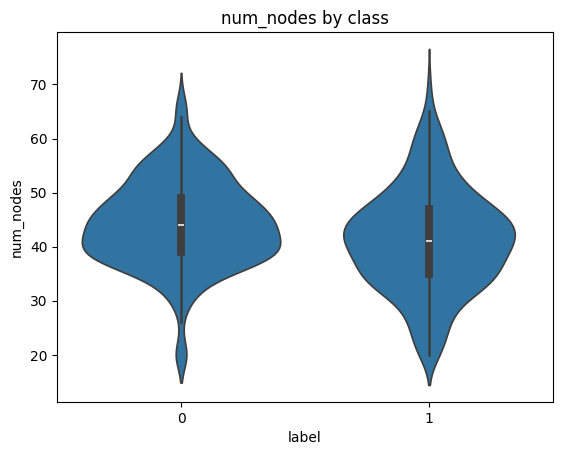

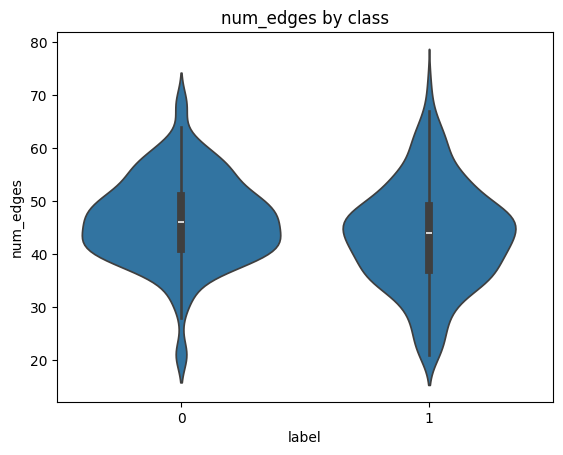

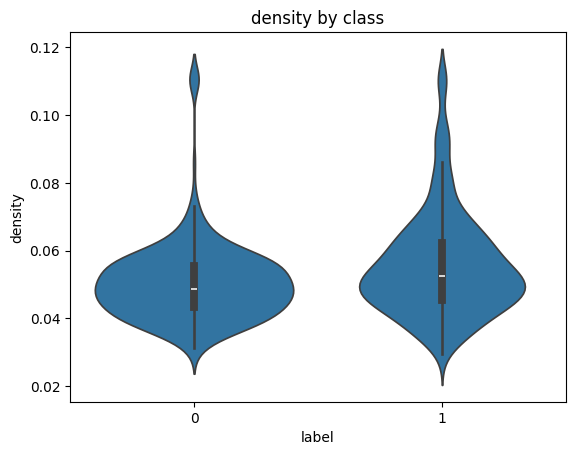

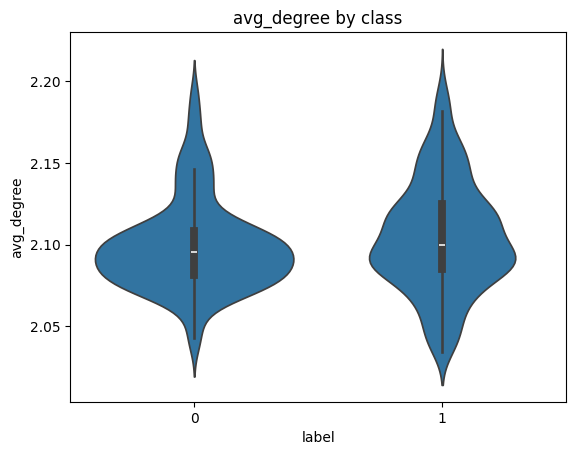

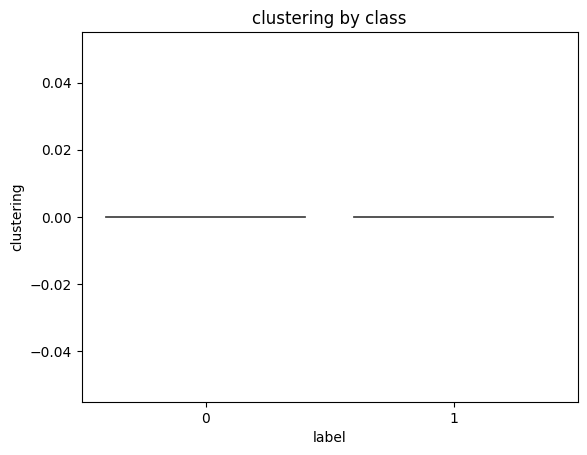

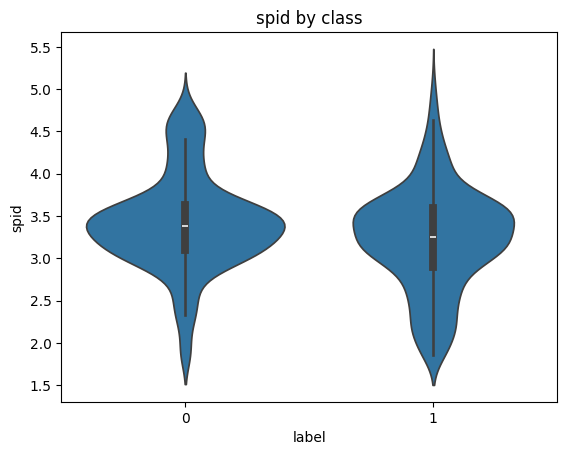

In [10]:
for feature in ['num_nodes', 'num_edges', 'density', 'avg_degree', 'clustering', 'spid']:
    sns.violinplot(x='label', y=feature, data=features_df)
    plt.title(f"{feature} by class")
    plt.show()

Overall conclusion:

There is clear evidence of structural imbalance between classes in the DHFR dataset:
	•	Class 0 graphs tend to be larger (more nodes/edges), less dense, and have more spread-out structures (higher SPID).
	•	Class 1 graphs tend to be smaller, denser, and more compact.
	•	These differences are statistically significant across multiple metrics (very low p-values).
	•	Clustering coefficient has no variance across graphs → not useful in this case.

“We observe statistically significant structural imbalance between classes in DHFR. Specifically, class 0 molecules tend to exhibit higher node and edge counts and broader topological spread (SPID), whereas class 1 graphs are denser and more compact. These differences (e.g., Δnodes: +3.0, p < 0.001) may explain the observed advantage of GNN models, which are inherently better at leveraging such structural signals compared to classical fingerprint-based baselines.”

The fact that fingerprints perform best overall suggests that functional substructures correlate strongly with class. Since fingerprints like ECFP4 hash subgraphs, they may indirectly capture the same global trends (e.g., more edges = more potential fragments). This may explain why classical models still perform very well on fingerprints.

While GCNs are well-suited for balanced, homophilic graph settings, they suffer when applied to structurally imbalanced molecular datasets like DHFR. In our experiments, the custom GNN architecture, which omits neighborhood normalization and incorporates skip connections, outperforms the GCN by a wide margin (ΔAccuracy ≈ 0.18; ΔAUC ≈ 0.32). This performance gain aligns with our structural analysis, which revealed significant topological divergence between classes in terms of node count, density, and shortest-path variability. The GNN’s architectural choices enable it to better preserve and leverage these structural signals, which are otherwise suppressed by normalization in the GCN.

In [11]:
# Example: Analyze DHFR
graphs, labels = load_graph_dataset('./AIDS/', 'AIDS')
features_df = get_features_df(graphs, labels)
comparison_df = compare_features(features_df)
print(comparison_df)

      feature  class0_mean  class1_mean     t_stat            t_p    u_stat  \
0   num_nodes    37.610000    10.213125  30.298248  1.108526e-105  638238.0   
1   num_edges    40.242500    10.183125  30.547483  9.372509e-107  637660.5   
2     density     0.073496     0.223552 -65.989543   0.000000e+00    2580.5   
3  avg_degree     2.133856     1.982618  23.324939  1.714323e-105  485001.0   
4  clustering     0.001794     0.008520  -4.833505   1.444829e-06  314187.0   
5        spid     4.355458     1.430845  26.727679   2.672979e-91  629469.5   

             u_p   cohen_d  
0  1.165503e-213  2.136044  
1  1.999294e-210  2.150807  
2  1.072687e-208 -3.112989  
3   9.597571e-60  0.948351  
4   8.330246e-02 -0.188656  
5  3.582910e-197  1.874906  


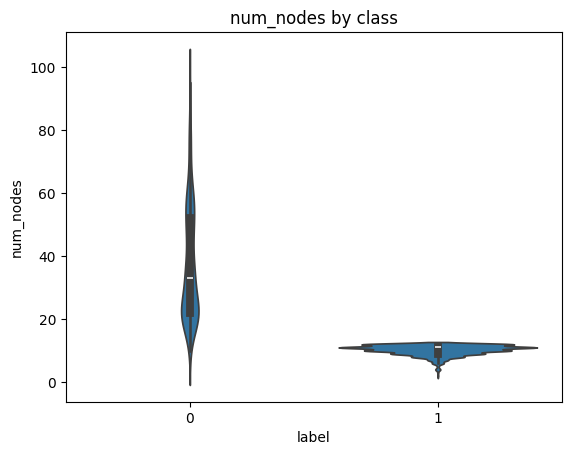

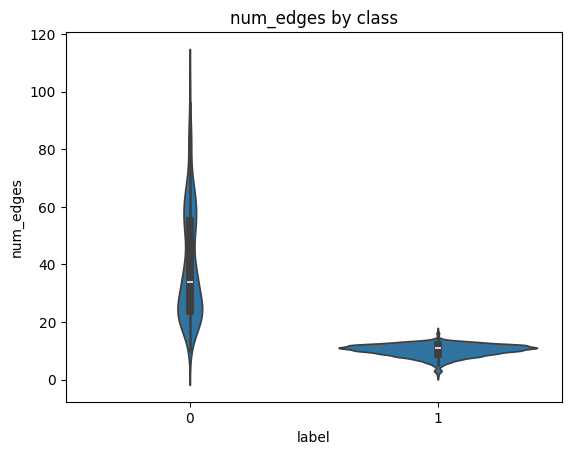

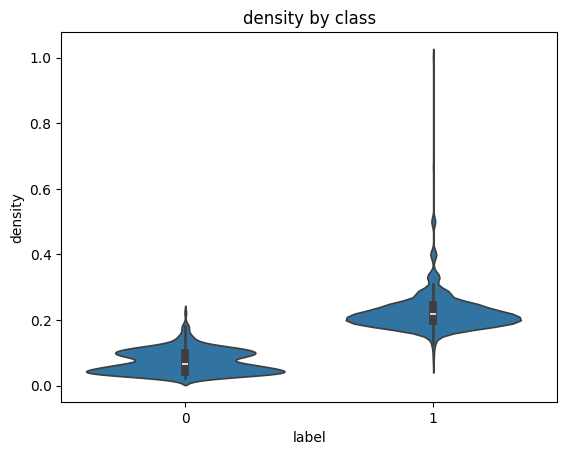

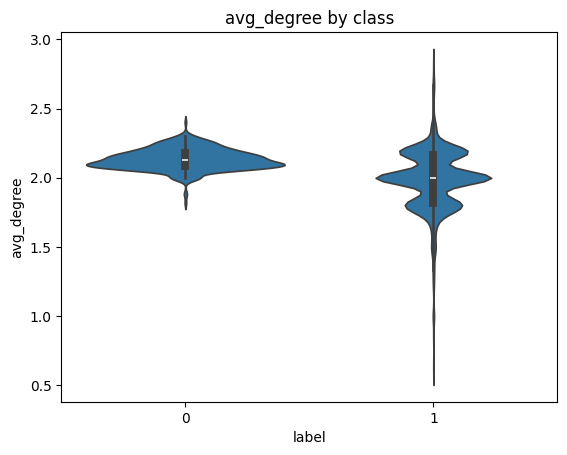

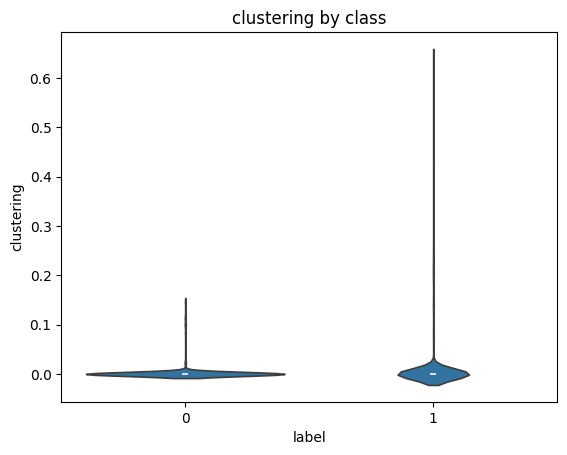

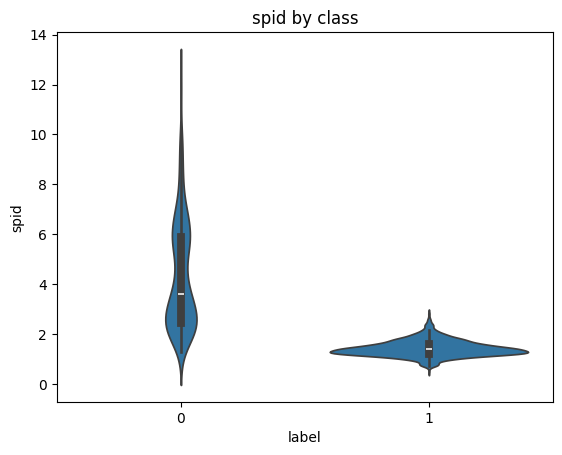

In [12]:
for feature in ['num_nodes', 'num_edges', 'density', 'avg_degree', 'clustering', 'spid']:
    sns.violinplot(x='label', y=feature, data=features_df)
    plt.title(f"{feature} by class")
    plt.show()

AIDS shows stronger and more extreme structural imbalance across all metrics.
Especially density, node count, and spid show very high effect sizes (|Cohen's d| > 2)
DHFR shows modest imbalance (effect sizes ~0.3–0.4), much less extreme.
Despite the much higher structural imbalance, classical models perform significantly better on AIDS than DHFR. Why?
In AIDS, class 0 and class 1 molecules differ drastically in structure (e.g., density 0.07 vs 0.22, spid 4.36 vs 1.43).
	•	These large, obvious differences are easily captured by classical models (even logistic regression).
	•	Fingerprints and graph metrics contain strongly correlated patterns with class.

→ The structural imbalance benefits learning, because it makes the class boundary simple to learn.
Graphs in AIDS dataset cluster by structure → good for linear and tree-based models.
	•	In contrast, DHFR shows more structural overlap, making the classification problem harder

“Interestingly, the AIDS dataset displays a significantly higher degree of structural imbalance between classes than DHFR, with effect sizes exceeding 2.0 in node count, edge count, and SPID. Yet, this imbalance correlates with better model performance, as the separability of classes becomes more trivial due to clear structural gaps. Classical machine learning models achieve near-perfect classification accuracy (up to 98%) using either fingerprints, graph-theoretic metrics, or node attributes. This contrasts with DHFR, where more subtle structural differences (Cohen’s d < 0.4) lead to lower performance and highlight the benefit of structure-sensitive models like GNNs.”

In [13]:
# Example: Analyze DHFR
graphs, labels = load_graph_dataset('./Mutagenicity/', 'Mutagenicity')
features_df = get_features_df(graphs, labels)
comparison_df = compare_features(features_df)
print(comparison_df)

      feature  class0_mean  class1_mean     t_stat           t_p     u_stat  \
0   num_nodes    29.374427    31.487603  -3.363780  7.767152e-04  2376201.5   
1   num_edges    30.282799    31.372934  -2.054676  3.998550e-02  2450585.5   
2     density     0.090264     0.092557  -1.518861  1.288807e-01  2344716.0   
3  avg_degree     2.069061     1.999453  17.815125  1.629263e-68  3165137.0   
4  clustering     0.004787     0.001036   8.868213  1.184090e-18  2465479.5   
5        spid     2.339938     2.401819  -2.065825  3.891724e-02  2417203.5   

            u_p   cohen_d  
0  2.041614e-01 -0.103933  
1  2.036705e-03 -0.063770  
2  6.161639e-01 -0.046804  
3  2.482109e-95  0.542527  
4  1.286807e-16  0.260460  
5  2.323363e-02 -0.063972  


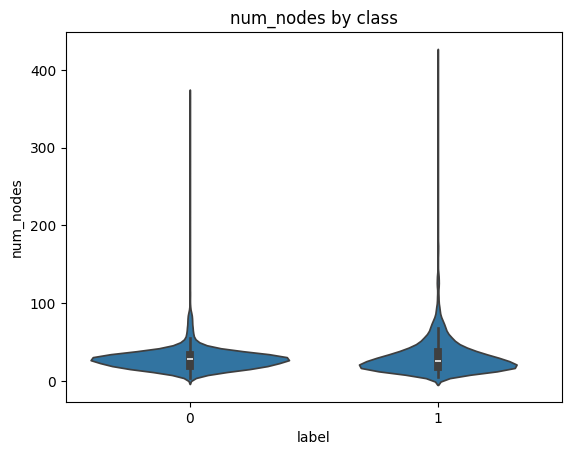

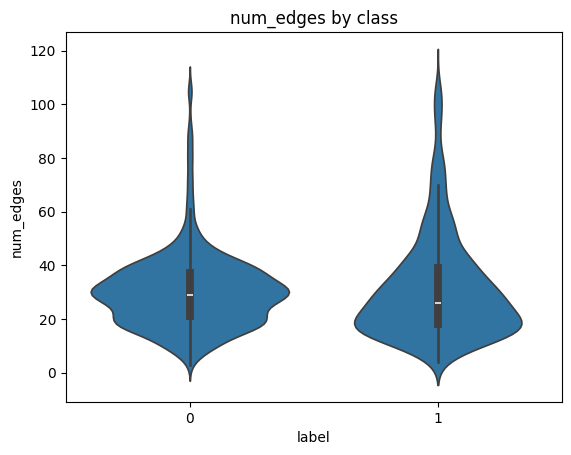

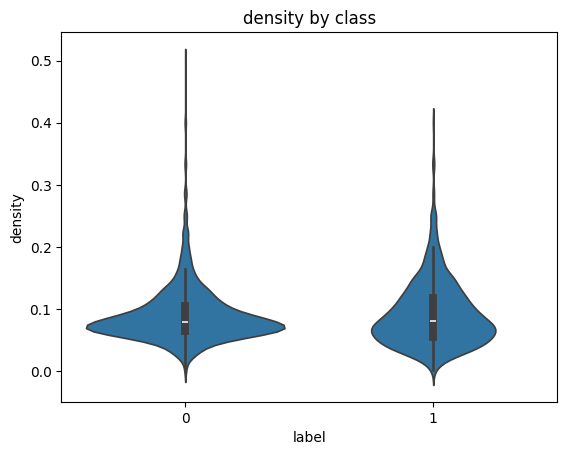

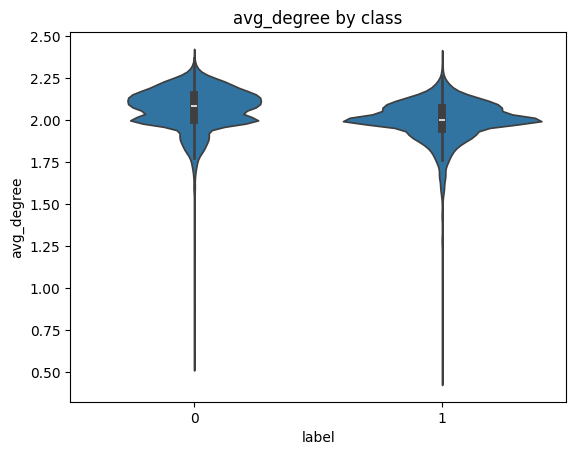

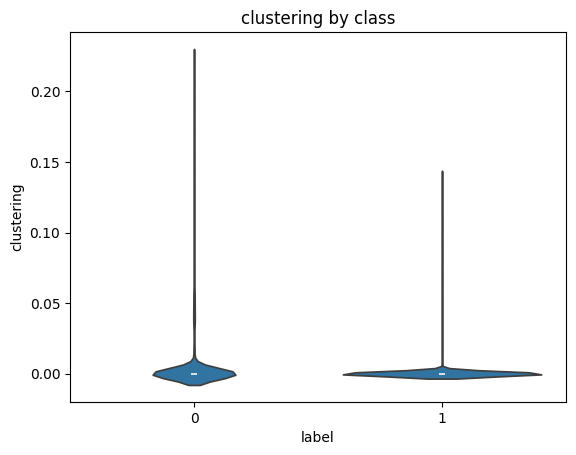

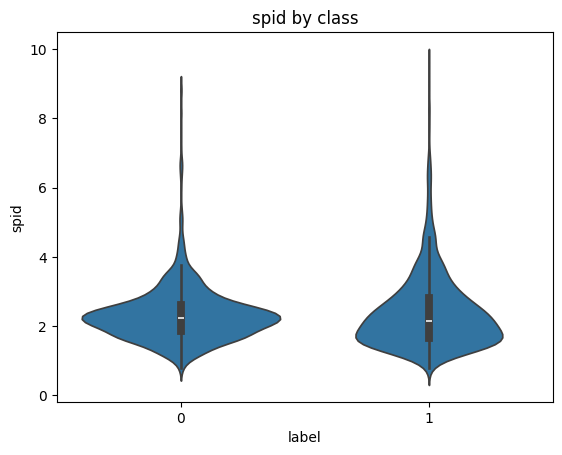

In [14]:
for feature in ['num_nodes', 'num_edges', 'density', 'avg_degree', 'clustering', 'spid']:
    sns.violinplot(x='label', y=feature, data=features_df)
    plt.title(f"{feature} by class")
    plt.show()

Mutagenicity has only mild structural imbalance, with avg_degree being the only moderately imbalanced feature (Cohen’s d = 0.54).
Most graph features in Mutagenicity have negligible effect sizes (|d| < 0.1–0.2).

even though large dataset performance not "better" than DHFR and def. not better than AIDS
	Unlike AIDS or DHFR, the structural properties of class 0 and class 1 graphs in Mutagenicity are too similar.
	•	There’s no strong graph-based pattern to exploit—class is not strongly encoded in structure.

The Mutagenicity dataset shows only mild structural imbalance, with most topological features exhibiting negligible differences between classes (Cohen’s d < 0.1). This structural similarity is reflected in the model performance: classical ML models achieve nearly identical accuracies across fingerprints, graph metrics, and combined features (≈75–77%). Unlike DHFR or AIDS, where structural differences can be leveraged for higher performance, Mutagenicity poses a more subtle classification task, suggesting the class-defining signal lies beyond global graph structure—potentially in more nuanced substructures or external chemical properties.”

In [15]:
# Example: Analyze DHFR
graphs, labels = load_graph_dataset('./PTC_MR/', 'PTC_MR')
features_df = get_features_df(graphs, labels)
comparison_df = compare_features(features_df)
print(comparison_df)

      feature  class0_mean  class1_mean    t_stat       t_p   u_stat  \
0   num_nodes    14.739583    13.717105  1.007461  0.314617  16946.0   
1   num_edges    15.119792    14.151316  0.855896  0.392814  16732.0   
2     density     0.194851     0.237710 -2.942624  0.003533  12106.5   
3  avg_degree     1.989685     1.968983  0.858702  0.391202  14675.5   
4  clustering     0.002222     0.018715 -2.115642  0.035964  14381.0   
5        spid     1.976643     1.815112  1.406740  0.160509  17036.0   

        u_p   cohen_d  
0  0.010105  0.111245  
1  0.019395  0.094490  
2  0.006625 -0.324529  
3  0.925812  0.094136  
4  0.450855 -0.242173  
5  0.007637  0.153547  


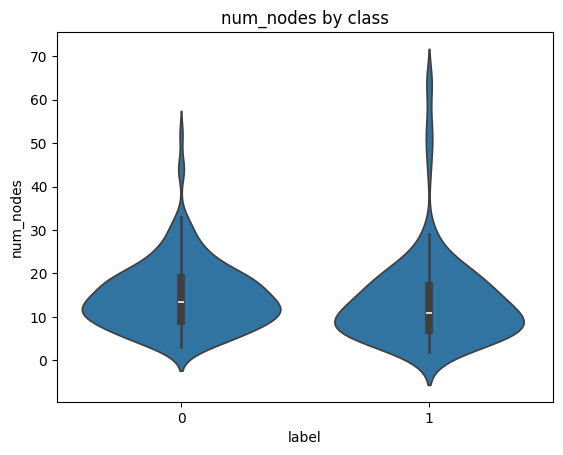

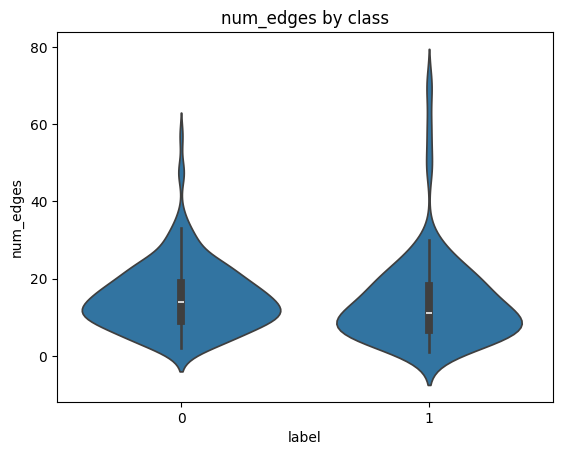

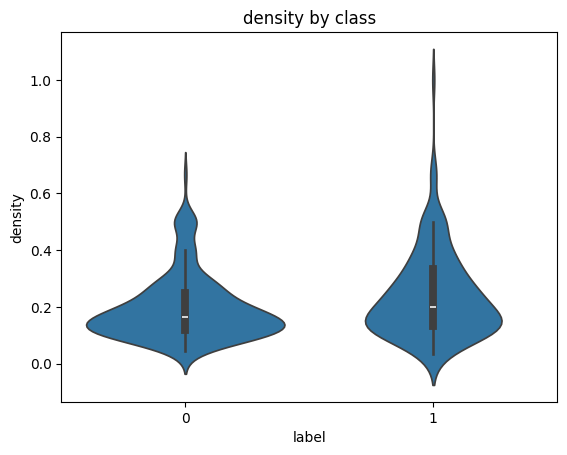

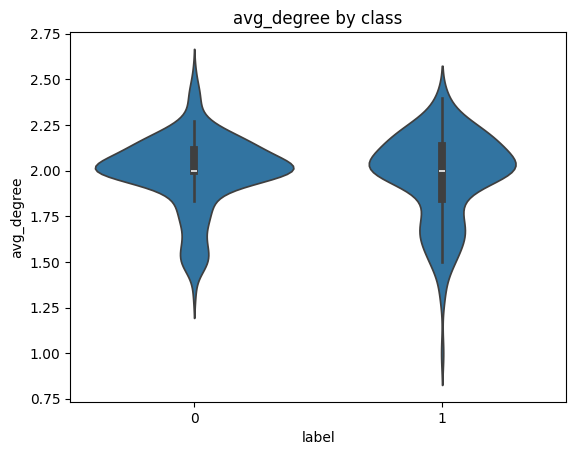

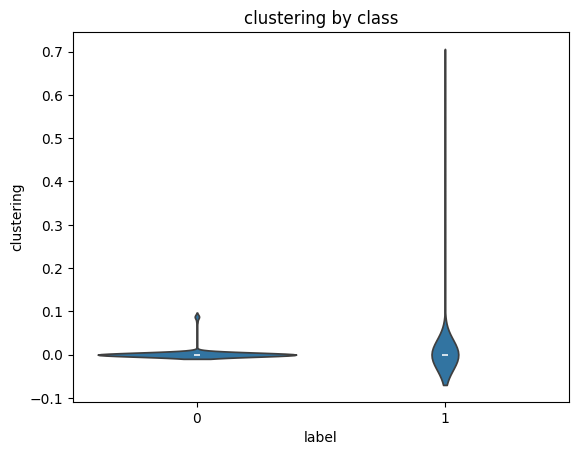

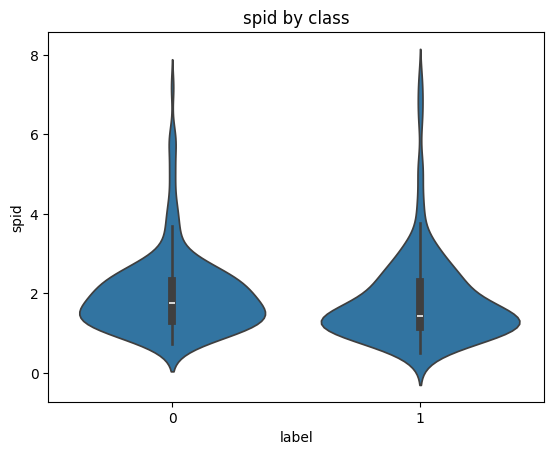

In [16]:
for feature in ['num_nodes', 'num_edges', 'density', 'avg_degree', 'clustering', 'spid']:
    sns.violinplot(x='label', y=feature, data=features_df)
    plt.title(f"{feature} by class")
    plt.show()

PTC_MR displays only weak structural imbalance.
	•	Density is the only feature with a borderline-moderate effect (Cohen’s d = -0.32), indicating class 1 graphs are slightly denser.
	•	Most features show negligible class-wise differences, similar to Mutagenicity, but even weaker.
    Overall accuracy is lowest among all datasets — none of the models crosses 65%.
	•	Graph-based performance is modest and almost flat across model types.
	•	No major synergy from combining fingerprints and graph features.


“The PTC_MR dataset displays only minimal structural imbalance across most topological features, with density being the only one showing a modest difference between classes (Cohen’s d = -0.32). This low imbalance aligns with the consistently low model performance across feature types, where no approach exceeds 64% accuracy. Combined feature models do not yield meaningful improvements over fingerprints or graph metrics alone. We attribute this to the dataset’s small size, weak topological class signals, and potential class overlap in both chemical structure and graph topology, which make PTC_MR a fundamentally harder classification task compared to structurally polarized datasets like AIDS or DHFR.”

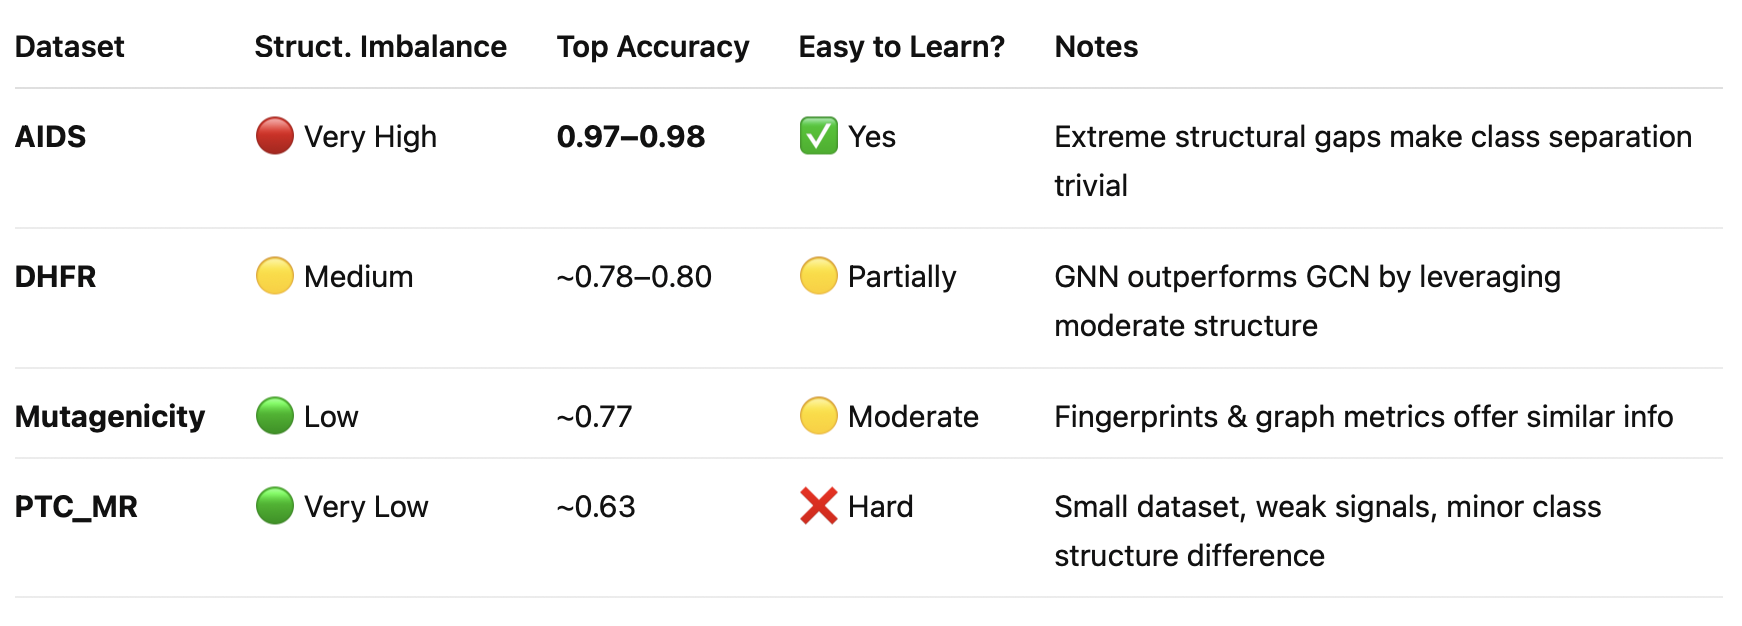